<a href="https://colab.research.google.com/github/AlkaidCheng/GSOC_MLHEP/blob/master/Exercise/TaskI/QMLHEP_Exercise_Machine_Learning_Part.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# QMLHEP Exercise Machine Learning Part

In [0]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import json

* download training data
* download tuned hyperparameters

In [2]:
!wget https://github.com/AlkaidCheng/GSOC_MLHEP/blob/master/Exercise/TaskI/QIS_EXAM_200Events.npz
!wget https://github.com/AlkaidCheng/GSOC_MLHEP/blob/master/Exercise/TaskI/best_hparams.json

--2020-03-14 20:38:12--  https://github.com/AlkaidCheng/GSOC_MLHEP/blob/master/Exercise/TaskI/QIS_EXAM_200Events.npz
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘QIS_EXAM_200Events.npz.5’

QIS_EXAM_200Events.     [ <=>                ]  65.64K  --.-KB/s    in 0.07s   

2020-03-14 20:38:13 (1001 KB/s) - ‘QIS_EXAM_200Events.npz.5’ saved [67219]

--2020-03-14 20:38:14--  https://github.com/AlkaidCheng/GSOC_MLHEP/blob/master/Exercise/TaskI/best_hparams.json
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘best_hparams.json.3’

best_hparams.json.3     [ <=>                ]  66.85K  --.-KB/s    in 0.06s   

2020-03-14 20:38:14 (1.01 MB/s) - ‘best_hparams.json.3

### Module Installer

In [0]:
import importlib

lightgbm_gpu_installed = False

def install_module(name):
  # need to reinstall lightgbm to allow gpu option
  if (name == 'lightgbm') and (not lightgbm_gpu_installed):
    ! pip install lightgbm --no-deps  --upgrade --force-reinstall --install-option=--gpu
  else:
    try:
      importlib.import_module(name)
    except ModuleNotFoundError:
      import subprocess as sp
      result = sp.run(
          ['pip', 'install', name],
          stdout=sp.PIPE, stderr=sp.PIPE
      )
      print(result.stdout.decode('utf-8'))
      if result.returncode != 0:
          print(result.stderr.decode('utf-8'))

### Data Loader
* Transform the `npz` data into the training input, test input, training labels and test labels with shuffling

In [0]:
# shuffle multiple set of arrays at the same time, e.g. input and labels
def shuffle_zippedarrays(arrays):
  shape = arrays[0].shape
  assert all(shape == arrays[0].shape for arr in arrays)
  index = np.random.permutation(shape[0])
  return [arr[index] for arr in arrays]

# shuffle input and labels
def shuffle_data(input, label):
  output = shuffle_zippedarrays([input,label])
  return output[0], output[1]

# data loader for arbitrary number of datasets (e.g. training, test, validation, ...) and multi-class labels (e.g. '0','1',...)
def load_data(arrays, shuffle = True):
  data = {}
  for key in arrays:
    input, label = np.array([]), np.array([])
    for klabel in arrays[key].item():
      _input = arrays[key].item()[klabel]
      _label = np.full((_input.shape[0],),int(klabel))
      input = np.concatenate((input,_input),axis=0) if input.size else _input
      label = np.concatenate((label,_label),axis=0) if label.size else _label
    if shuffle:
      input, label = shuffle_data(input, label)
    data[key] = {'input': input, 'label': label}
  return data

# split the data into the training input, test input, training labels and test labels
def load_train_test_input_labels(arrays, shuffle = True):
  data = load_data(arrays, shuffle)
  return data['training_input']['input'], data['test_input']['input'], data['training_input']['label'], data['test_input']['label']

* load the training data

In [0]:
data = np.load('QIS_EXAM_200Events.npz',allow_pickle=True)
train_input, test_input, train_label, test_label = load_train_test_input_labels(data)

### Model Loader
* loading different models with tuned hyperparameters from `best_hparams.json`
* for details about hyperparameter tuning, see the notebooks from the `HParamTuning` directory

In [0]:
# load tuned hyperparameters
tuned_hparams = json.load(open('best_hparams.json'))

def get_model(model, tuned = True, gpu = True):
  # assign hyperparameters
  if (tuned == True) and (model in tuned_hparams):
    param = tuned_hparams[model]
  else:
    param = {}

  # create models 
  if model == 'RandomForest':
    from sklearn.ensemble import RandomForestClassifier
    return RandomForestClassifier(**param)
  elif model == 'DecisionTree':
    from sklearn.tree import DecisionTreeClassifier
    return DecisionTreeClassifier(**param)
  elif model == 'xgboost':
    install_module('xgboost')
    import xgboost
    if gpu:
      return xgboost.XGBClassifier(tree_method = 'gpu_hist', **param)
    else:
      return xgboost.XGBClassifier(tree_method="hist", thread_count=-1, **param)
  elif model == 'lightgbm':
    install_module('lightgbm')
    import lightgbm
    if gpu:
      return lightgbm.LGBMClassifier(device_type ="gpu", **param)
    else:
      return lightgbm.LGBMClassifier(num_threads=-1, **param)
  elif model == 'catboost':
    install_module('catboost')
    import catboost
    if gpu:
      return catboost.CatBoostClassifier( **param)
    else:
      return catboost.CatBoostClassifier(thread_count=-1, **param)
  elif model == 'svm':
    from sklearn.svm import SVC
    return SVC(probability = True, **param)
  elif model == 'nn':
    import torch
    from torch import nn
    import torch.nn.functional as F
    from skorch import NeuralNetClassifier
    torch.manual_seed(0);
    net = NeuralNetClassifier(**parm)
    return net

### ROC Curve Plotter

In [0]:
from sklearn.metrics import roc_curve, auc

def plot_roc(model, model_name, save = True):
  fpr,tpr,_ = roc_curve(test_label,model.predict_proba(test_input)[:,1])	
  auc_score = auc(fpr, tpr)
  plt.clf()
  plt.xlabel("Signal efficiency", fontsize = 18, fontweight = 'bold')
  plt.ylabel("Background rejection", fontsize = 18, fontweight = 'bold')
  plt.title(model_name+" ROC Curve", fontsize = 16, fontweight = 'bold')
  plt.xlim(0.0,1.0)
  plt.ylim(0.0,1.0)
  plt.grid(color='gray',linestyle='--',linewidth=1)
  plt.plot(tpr,1-fpr,'r--',label=model_name+', auc = %0.3f'%auc_score,linewidth = 2)
  plt.plot([0,1],[1,0],linestyle='--',color='black',label='Luck, auc = 0.5')
  plt.legend(loc='best')
  if save:
    plt.savefig('{}_roc.eps'.format(model_name.lower()))
    plt.savefig('{}_roc.png'.format(model_name.lower()))

## Trying out different Machine Learning Models

In [0]:
model_name_mapper = {
    'DecisionTree': 'DecisionTree',
    'RandomForest': 'RandomForest',
    'SVM': 'svm',
    'XGBoost': 'xgboost',
    'LightGBM' : 'lightgbm',
    'CatBoost' : 'catboost'
}

def try_model(name, plot = True):
  model = get_model(model_name_mapper[name])
  model.fit(train_input,train_label)
  if plot:
    plot_roc(model, name)
  return model

### Decision Tree Classifier

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=29, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=8, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

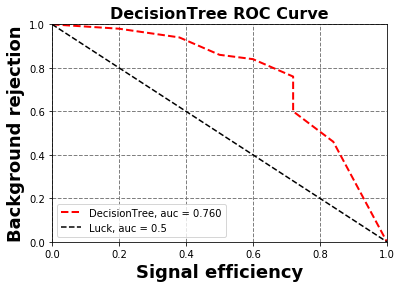

In [9]:
# Note that results from decision tree is not stable
try_model('DecisionTree')

### Random Forest Classifier

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=1, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=6,
                       min_weight_fraction_leaf=0.0, n_estimators=280,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

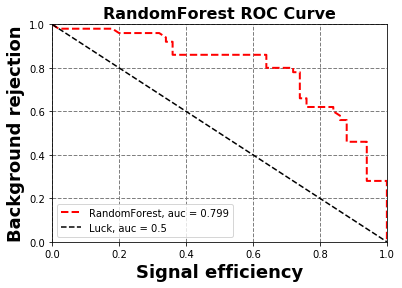

In [10]:
# Note that results from random forest is not stable (but more stable than decision tree)
try_model('RandomForest')

### Support Vector Machine (SVM) Classifier

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


SVC(C=24.678539630231498, break_ties=False, cache_size=200, class_weight=None,
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma='auto',
    kernel='linear', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

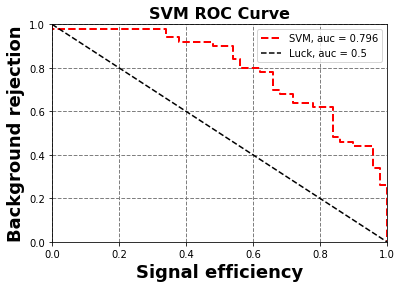

In [11]:
try_model('SVM')

### XGBoost Classifier

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9726979433987133,
              eta=0.013692988629520534, eval_metric='logloss',
              gamma=3.990499197892894, grow_policy='lossguide',
              learning_rate=0.1, max_delta_step=0, max_depth=21,
              min_child_weight=8.0, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, num_threads=4, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=0.7025619513749428,
              tree_method='gpu_hist', verbosity=0)

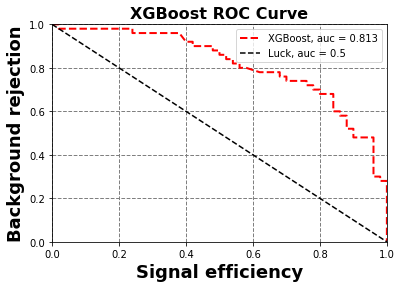

In [12]:
try_model('XGBoost')

### LightGBM Classifier

/usr/local/lib/python3.6/dist-packages/pip/_internal/commands/install.py:283: UserWarning: Disabling all use of wheels due to the use of --build-options / --global-options / --install-options.
  cmdoptions.check_install_build_global(options)
  Using cached https://files.pythonhosted.org/packages/d2/90/4a75304dae29ae4b2497ed01b12e7c0a8f12f981c086f086b5416d28bf07/lightgbm-2.3.1.tar.gz
Skipping wheel build for lightgbm, due to binaries being disabled for it.
  Found existing installation: lightgbm 2.3.1
    Uninstalling lightgbm-2.3.1:
      Successfully uninstalled lightgbm-2.3.1
    Running setup.py install for lightgbm ... done


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


LGBMClassifier(boosting_type='gbdt', class_weight=None,
               colsample_bytree=0.8186783735937218, device_type='gpu',
               importance_type='split', learning_rate=0.04669483279255087,
               max_depth=-1, metric='binary_logloss', min_child_samples=20,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
               n_jobs=-1, num_leaves=714, objective='binary', random_state=None,
               reg_alpha=0.6570397599979627, reg_lambda=0.03784950639114426,
               silent=True, subsample=0.8069159416588685,
               subsample_for_bin=200000, subsample_freq=0, verbose=0)

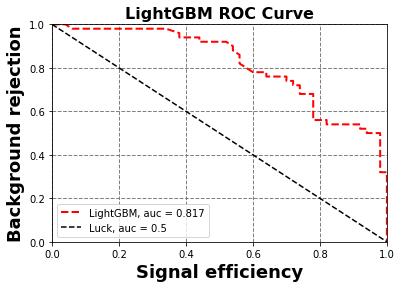

In [13]:
# note that it may take several minutes to install lightgbm with gpu
try_model('LightGBM')

### CatBoost Classifier

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


0:	total: 47.6ms	remaining: 4.72s
1:	total: 48.1ms	remaining: 2.35s
2:	total: 48.3ms	remaining: 1.56s
3:	total: 48.5ms	remaining: 1.16s
4:	total: 48.6ms	remaining: 924ms
5:	total: 48.9ms	remaining: 766ms
6:	total: 49.1ms	remaining: 652ms
7:	total: 49.3ms	remaining: 567ms
8:	total: 49.6ms	remaining: 501ms
9:	total: 49.8ms	remaining: 448ms
10:	total: 50ms	remaining: 404ms
11:	total: 50.2ms	remaining: 368ms
12:	total: 50.4ms	remaining: 337ms
13:	total: 50.6ms	remaining: 311ms
14:	total: 50.8ms	remaining: 288ms
15:	total: 51ms	remaining: 268ms
16:	total: 51.2ms	remaining: 250ms
17:	total: 51.3ms	remaining: 234ms
18:	total: 51.5ms	remaining: 220ms
19:	total: 51.7ms	remaining: 207ms
20:	total: 51.8ms	remaining: 195ms
21:	total: 52ms	remaining: 184ms
22:	total: 52.2ms	remaining: 175ms
23:	total: 52.4ms	remaining: 166ms
24:	total: 52.5ms	remaining: 158ms
25:	total: 52.7ms	remaining: 150ms
26:	total: 52.9ms	remaining: 143ms
27:	total: 53.1ms	remaining: 136ms
28:	total: 53.2ms	remaining: 130ms
2

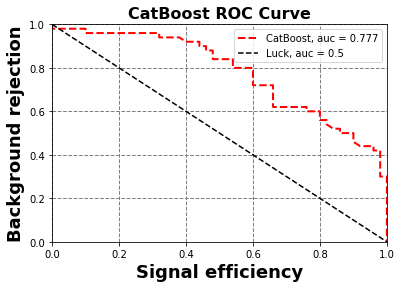

In [14]:
try_model('CatBoost')

## Feature Importance

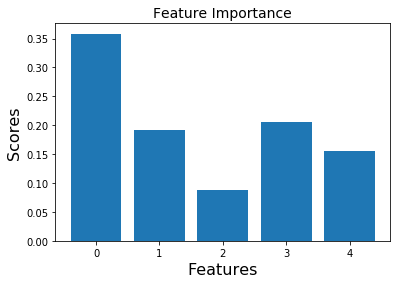

In [15]:
model = try_model('XGBoost',plot = False)
plt.clf()
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.ylabel('Scores', fontsize=16)
plt.xlabel('Features', fontsize=16)
plt.title('Feature Importance', fontsize=14)
plt.savefig('feature_importance.eps')
plt.savefig('feature_importance.png')

## Neural Network (not implemented)

In [16]:
install_module('skorch')
import torch
from torch import nn
import torch.nn.functional as F
from skorch import NeuralNetClassifier
torch.manual_seed(0)
class ClassifierModule(nn.Module):
    def __init__(
            self,
            num_units=10,
            nonlin=F.relu,
            dropout=0.5,
    ):
        super(ClassifierModule, self).__init__()

        self.dense0 = nn.Linear(20, num_units)
        self.nonlin = nonlin
        self.dropout = nn.Dropout(dropout)
        self.dense1 = nn.Linear(num_units, 10)
        self.output = nn.Linear(10, 2)

    def forward(self, X, **kwargs):
        X = self.nonlin(self.dense0(X))
        X = self.dropout(X)
        X = F.relu(self.dense1(X))
        X = F.softmax(self.output(X), dim=-1)
        return X

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
